In [1]:
import memory_profiler as mem_profile
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm.auto import tqdm

from transformers.image_transforms import rgb_to_id
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation
from huggingface_hub import hf_hub_download

import albumentations as A

import torch
from torch.utils.data import DataLoader, Dataset

print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [71.08984375]MB
Memory (After) : [512.39453125]MB


In [2]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, processor, transform=None):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.processor = processor
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]["image"])
        panoptic_seg_gt = np.array(self.dataset[idx]['label'])

        # apply transforms (need to be applied on RGB values)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=panoptic_seg_gt)
            image, panoptic_seg_gt = transformed['image'], transformed['mask']
            # convert to C, H, W
            image = image.transpose(2,0,1)
        
        panoptic_seg_gt = rgb_to_id(panoptic_seg_gt)
        inst2class = {segment['id']: segment['category_id'] for segment in self.dataset[idx]['segments_info']}

        inputs = self.processor([image], [panoptic_seg_gt], instance_id_to_semantic_id=inst2class, return_tensors="pt")
        inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

# define custom collate function which defines how to batch examples together
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}



def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [513.0703125]MB
Memory (After) : [513.0703125]MB


In [3]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
dataset = load_dataset("nielsr/ade20k-panoptic-demo")
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [513.0703125]MB


Found cached dataset parquet (C:/Users/Antonin_Joly/.cache/huggingface/datasets/nielsr___parquet/nielsr--ade20k-panoptic-demo-4342d0608d46a86c/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/2 [00:00<?, ?it/s]

Memory (After) : [517.62890625]MB


Memory (Before): [517.72265625]MB


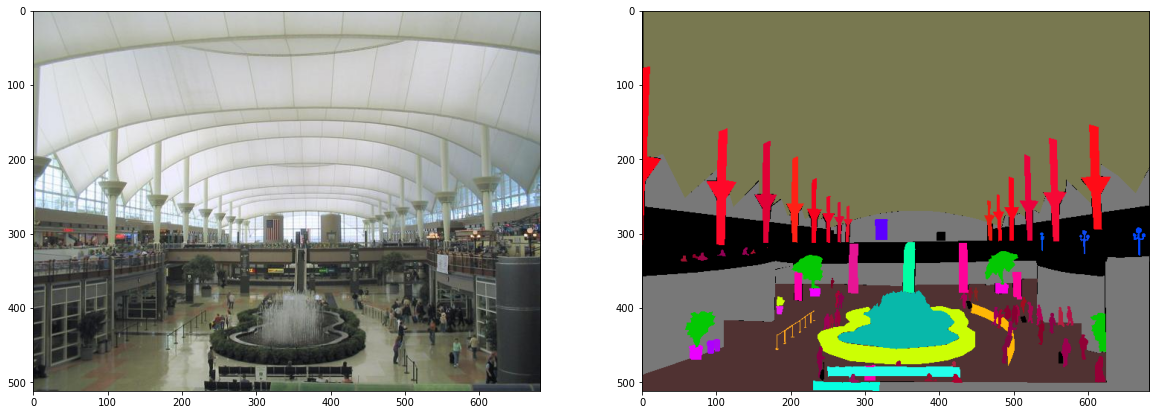

Memory (After) : [529.9296875]MB


In [4]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
idx = 0
example = dataset["train"][idx]
image = example["image"]
label = example['label']
info = example['segments_info']

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(label)
plt.show()
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

In [5]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
# convert RGB to segment IDs per pixel
# 0 is the "ignore" label, for which we don't need to make binary masks
panoptic_map = rgb_to_id(np.array(label))
inst2class = {segment['id']: segment['category_id'] for segment in info}
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [530.046875]MB
Memory (After) : [531.57421875]MB


In [6]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
# the categories are the regular 150 classes of ADE20k
repo_id = f"huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [531.58203125]MB
Memory (After) : [531.60546875]MB


Memory (Before): [531.66796875]MB
Memory (After) : [532.265625]MB


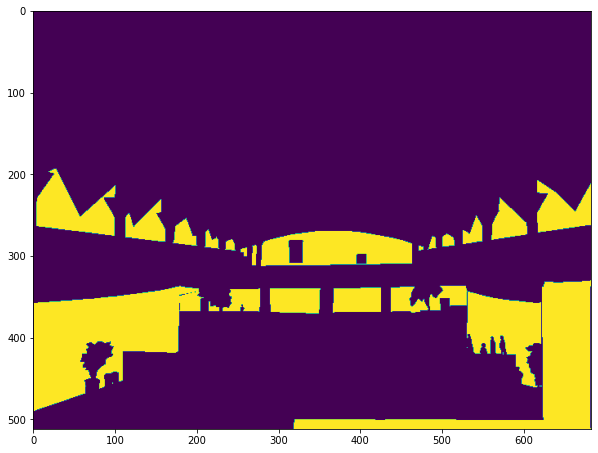

In [7]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
mask = (panoptic_map == 7895160)
mask = (mask * 255).astype(np.uint8)

plt.figure(figsize=(10,10))
plt.imshow(mask)
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

In [8]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
# we don't want to reduce labels here
# we set resizing, rescaling and normalizing here to False as we'll use Albumentations for that (see further)
processor = MaskFormerImageProcessor(ignore_index=0, do_resize=False, do_rescale=False, do_normalize=False)
# prepare image + label for the model
inputs = processor(image, panoptic_map, instance_id_to_semantic_id=inst2class, return_tensors="pt")
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [539.62109375]MB
Memory (After) : [644.0625]MB


In [9]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

image_transform = A.Compose([A.Resize(width=512, height=512),A.Normalize(mean=ADE_MEAN, std=ADE_STD),])

train_dataset = ImageSegmentationDataset(dataset["train"], processor, transform=image_transform)
test_dataset = ImageSegmentationDataset(dataset["validation"], processor, transform=image_transform)
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [644.11328125]MB
Memory (After) : [644.11328125]MB


In [10]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
# batch = next(iter(train_dataloader))
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [644.11328125]MB
Memory (After) : [644.18359375]MB


In [11]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-coco",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)
# # verify forward pass
# outputs = model(pixel_values=batch["pixel_values"], mask_labels=batch["mask_labels"], class_labels=batch["class_labels"],)
# outputs.loss
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [644.18359375]MB


Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-coco and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([151, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([151]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([151]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Memory (After) : [1045.18359375]MB


In [12]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
running_loss = 0.0
num_samples = 0

for epoch in range(5):
    print("Epoch:", epoch)
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                        class_labels=[labels.to(device) for labels in batch["class_labels"]],)

        # Backward propagation
        loss = outputs.loss
        loss.backward()

        batch_size = batch["pixel_values"].size(0)
        running_loss += loss.item()
        num_samples += batch_size

        if idx % 5 == 0:
            print("Loss:", running_loss/num_samples)
        optimizer.step()
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [1045.1875]MB
Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.0038225650787354
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8044593334198
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5250727371736006
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2968914955854416
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1898421560015
Memory (After) : [2369.8203125]MB


In [13]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
idx = 0
image = dataset["train"][idx]["image"]
pixel_values = image_transform(image=np.array(image))["image"]
pixel_values = np.moveaxis(pixel_values, -1, 0)
pixel_values = torch.from_numpy(pixel_values).unsqueeze(0)
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [2369.8203125]MB
Memory (After) : [2374.32421875]MB


In [14]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
with torch.no_grad():
    outputs = model(pixel_values.to(device))
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

Memory (Before): [2374.32421875]MB
Memory (After) : [2348.05859375]MB


In [17]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
seg = results['segmentation'].cpu().numpy()
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')

`label_ids_to_fuse` unset. No instance will be fused.


Memory (Before): [2351.36328125]MB
Memory (After) : [2351.3671875]MB


Memory (Before): [2351.453125]MB


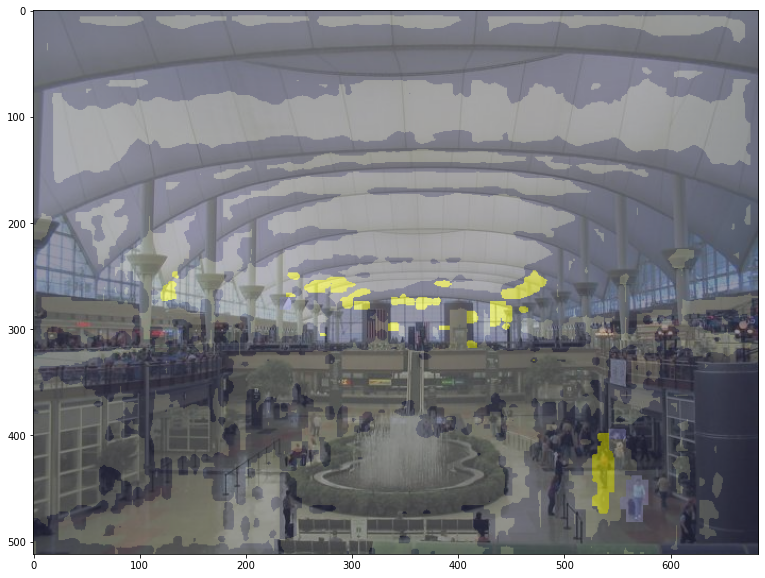

Memory (After) : [2356.58203125]MB


In [18]:
print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()
print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')